In [2]:
import os,sys,itertools,math,logging,json,re,random,time,datetime,shutil
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import matplotlib.path as mplPath
ROOT_DIR = os.getcwd()
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils,visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import obstacle
import cv2,skimage
import time
import glob
import pickle
%matplotlib inline

In [3]:
def load_settings(min_dim=300,max_dim=320,device='/cpu:0'): 
    config=obstacle.ObstacleConfig()
    with tf.device(device):
        model = modellib.MaskRCNN(mode="inference", model_dir=ROOT_DIR,config=config)
    
    weights_path=os.path.join(ROOT_DIR,'mask_rcnn_obstacle_0025_resnet50.h5')
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)
    
    return config,model

def image_detection(path,model):
    #_,model=load_settings()
    r_total={}
    def get_ax(rows=1, cols=1, size=10):
        """Return a Matplotlib Axes array to be used in
        all visualizations in the notebook. Provide a
        central point to control graph sizes.
        
        Adjust the size attribute to control how big to render images
        """
        _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
        return ax
    image_names=glob.glob(path+"\*.png")
    for i in image_names:
        start=time.time()
        image=cv2.imread(i)
        
        
        # Get predictions of mask head

        mrcnn = model.run_graph([image], [
            ("detections", model.keras_model.get_layer("mrcnn_detection").output),
            ("masks", model.keras_model.get_layer("mrcnn_mask").output),
        ])

        # Get detection class IDs. Trim zero padding.
        det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
        det_count = np.where(det_class_ids == 0)[0][0]
        det_class_ids = det_class_ids[:det_count]

        # Masks
        det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
        det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                                      for i, c in enumerate(det_class_ids)])
        det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                              for i, m in enumerate(det_mask_specific)])

        mask=np.zeros([256,256],dtype=int)
        for a in range(0,len(det_masks)):
            mask=(mask==1)|(det_masks[a]==1)

        #fig = plt.figure()
        #ax = fig.add_subplot(111)
        #ax.imshow(mask, aspect='auto')

        listk = []    #---stores coordinate corresponding to height of the image
        listj = []    #---stores coordinate corresponding to width of the image

        for k in range(0, mask.shape[0]):
            for j in range(0, mask.shape[1]):
                if(mask[k, j]==True):
                    listk = np.append(listk, k)
                    listj = np.append(listj, j)

        plt.scatter(listj,-listk)
        plt.show()
        
        results = model.detect([image], verbose=1)
        #Display results
        ax = get_ax(1)
        r = results[0]
        #r['image_id']=i.split('\\')[-1]
        r['x_detections']=listj
        r['y_detections']=listk
        end=time.time()
        print("Time taken to run detection : ",end-start)
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], r['scores'], ax=ax,title="Predictions")
        r_total[i.split('\\')[-1]]=r
        
    
    with open('data.p', 'wb') as fp:
        pickle.dump(r_total, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    return image_names,model,r_total

In [4]:
_,model=load_settings()

Loading weights  C:\Users\DELL PC\Desktop\Savera\Final_Model\mask_rcnn_obstacle_0025_resnet50.h5


detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00220  max:    0.99951  float32


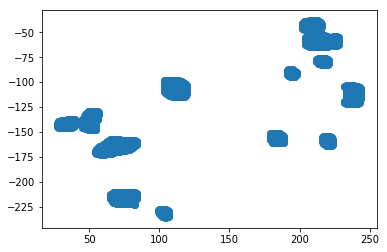

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32
Time taken to run detection :  6.503962755203247


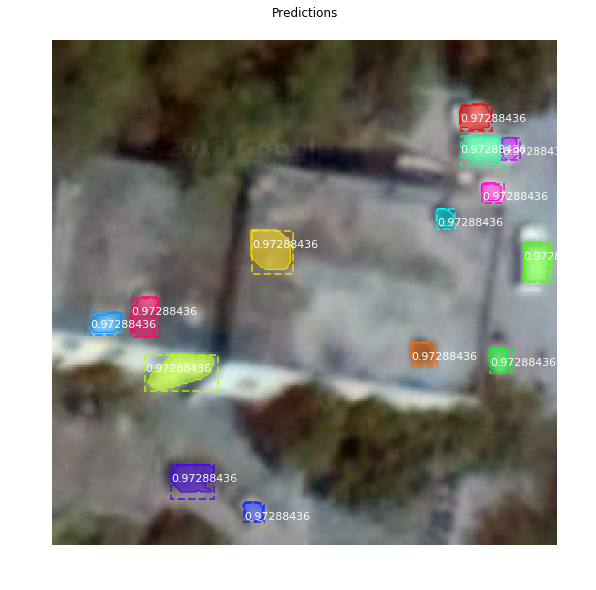

In [5]:
image_names,_,r_net=image_detection(ROOT_DIR+'\\test',model)

In [6]:
#Loading pickle file
with open('data.p', 'rb') as fp:
    data = pickle.load(fp)

In [7]:
data

{'2_244.png': {'rois': array([[234,  97, 244, 107],
         [102, 239, 122, 254],
         [137,  19, 149,  35],
         [153, 182, 165, 195],
         [ 48, 207,  63, 230],
         [156, 222, 168, 233],
         [ 32, 207,  45, 223],
         [215,  60, 232,  82],
         [130,  40, 150,  54],
         [ 72, 218,  82, 229],
         [ 85, 195,  95, 204],
         [ 96, 101, 118, 122],
         [ 49, 228,  60, 237],
         [159,  47, 177,  84]]),
  'class_ids': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'scores': array([0.9731174 , 0.97288436, 0.9694643 , 0.9643815 , 0.96358025,
         0.9589813 , 0.94174576, 0.9400755 , 0.93754566, 0.9227429 ,
         0.9009282 , 0.88204134, 0.8672153 , 0.8373462 ], dtype=float32),
  'masks': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, Fal